**LIBRARY MANAGEMENT**

In [1]:
# Installing necessary packages that are not pre-installed in Google Colab
!pip install deepdish
!pip install numpy==1.15.4

In [2]:
# Importing required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

from imgaug import augmenters as iaa
from imgaug import parameters as iap

**DATA ACQUISITION**

In [3]:
# Connection with Google Drive for Data Acquisition
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ISIC_Dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Data Acquisition
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [5]:
# Separating data into images (X) and labels (Y)
X = data_df.image
Y = data_df.cell_type_idx

**DATA PREPROCESSING**

In [6]:
# EDA: Value count of data categories
data_df.cell_type.value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [7]:
# Function definition: balance_and_augmentation_data
## Given a unbalanced dataset, this function carries out a data balance by 
## applying data augmentation. Given a number of images per class, the function
## returns a dataset with all the categories with the same number of data.

def balance_and_augmentation_data(X, Y, num_muestras_clase): 

  """
  Input params: X, Y, num_muestras_clase
  Output params: X_bal, Y_bal
  """

  X = np.array(X)
  Y = Y.to_numpy()

  # Definition of basic information: images size, number of categories and
  # inital number of samples per category.
  rows, cols, depth = X[0].shape
  num_clases = pd.DataFrame(Y).nunique()[0]
  num_muestras_init = pd.DataFrame(Y).value_counts()

  # Initializing the new dataset
  X_bal = np.zeros((num_clases*num_muestras_clase, rows, cols, depth), 
                   dtype = np.uint8)
  Y_bal = np.zeros((num_clases*num_muestras_clase,), dtype = np.uint8)
  '''
  # Se define el operador para data augmentation
  seq = iaa.Sequential([
      iaa.GaussianBlur(
          sigma=iap.Uniform(0.0, 1.0)
      ),
      iaa.Affine(
          rotate=iap.Normal(0.0, 30),
          translate_px=iap.RandomSign(iap.Poisson(3))
      )
  ])
  '''
  # Definition of Data Augmentation operator
  seq = iaa.Sequential([
      #iaa.Fliplr(0.5), # horizontal flips
      #iaa.Crop(percent=(0, 0.1)), # random crops
      iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 1.0))), # small gausian blur
      # Add gaussian noise.
      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
      # Apply affine transformations to each image.
      # Scale/zoom them, translate/move them, rotate them and shear them.
      #iaa.Affine(
      #    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
      #    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
      #    rotate=(-40, 40),
      #    shear=(-8, 8),
      #    order = 0,
      #    cval=(0, 255),
      #)
  ], random_order=True)

  # Definition of another Data Augmentation operator
  img_augmentation = Sequential(
      [
          preprocessing.RandomRotation(factor=0.15),
          preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
          preprocessing.RandomFlip(),
          preprocessing.RandomContrast(factor=0.1),
      ],
      name="img_augmentation",
  )

  # Initializing counter
  next_idx = 0
  
  # For each category, we iterate filling the new dataset with existing data and
  # complete to the desired number of data per class with data augmentation
  # images from the previously defined operator.
  for cat in range(num_clases):

    print('Data Balance for Class {} with {} original images'.format(cat, 
                                              num_muestras_init[cat].values[0]))

    # Number images to generate with data augmentation operator.
    n_imgs_generate = num_muestras_clase - num_muestras_init[cat].values[0]
    # Indexes of original images of current category in the original dataset.
    idx_imgs_cat = np.where(Y == cat)[0]
    
    # Complete the new dataset with original data
    for idx, img in enumerate(idx_imgs_cat):
      if idx < num_muestras_clase:
        X_bal[next_idx,:,:,:] = X[img]
        Y_bal[next_idx] = Y[img]
        next_idx += 1
      else:
        break

    # Complete the new dataset with new data generated by data augmentation
    # operator.
    if n_imgs_generate > 0:
      idx_new_imgs = np.random.randint(0, num_muestras_init[cat].values[0], 
                                       n_imgs_generate)
      for idx in idx_new_imgs:
        modified_image = seq.augment_image(X[idx_imgs_cat[idx]])
        X_bal[next_idx,:,:,:] = img_augmentation(tf.expand_dims(modified_image,
                                                                axis=0))
        Y_bal[next_idx] = cat
        next_idx += 1

  return X_bal, Y_bal 

In [8]:
# Separate the original dataset into train set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1997)

In [9]:
# Resizing the test set into shape (None, 75, 100, 3)
X_test_old = np.array(X_test)
num_test_muestras = X_test_old.shape[0]
X_test = np.zeros((num_test_muestras, 75, 100, 3), dtype = np.uint8)

for i in range(num_test_muestras):
  X_test[i,:,:,:] = X_test_old[i]

In [10]:
# Balancing the train set
X_train, Y_train = balance_and_augmentation_data(X_train, Y_train, 6000)
pd.Series(Y_train).value_counts()

Data Balance for Class 0 with 268 original images
Data Balance for Class 1 with 401 original images
Data Balance for Class 2 with 881 original images
Data Balance for Class 3 with 89 original images
Data Balance for Class 4 with 5371 original images
Data Balance for Class 5 with 891 original images
Data Balance for Class 6 with 111 original images


6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [11]:
# Separate train set into train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state = 2020)

In [12]:
print('X_train shape: {}'.format(X_train.shape))
print('Y_train shape: {}'.format(Y_train.shape))
print('-'*30)
print('X_test shape: {}'.format(X_test.shape))
print('Y_test shape: {}'.format(Y_test.shape))

X_train shape: (37800, 75, 100, 3)
Y_train shape: (37800,)
------------------------------
X_test shape: (2003, 75, 100, 3)
Y_test shape: (2003,)


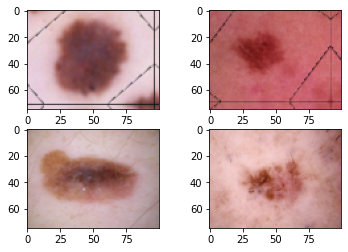

In [13]:
# Showing some train and test images
fig = plt.figure()

plt.subplot(221)
plt.imshow(X_train[100], cmap = 'Greys')
plt.subplot(222)
plt.imshow(X_train[600], cmap = 'Greys')
plt.subplot(223)
plt.imshow(X_test[100], cmap = 'Greys')
plt.subplot(224)
plt.imshow(X_test[600], cmap = 'Greys')

plt.show()

In [14]:
# Data preprocessing

# Image normalization
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))
X_val = (X_val / np.max(X_val))

# Converting labels to one hot encoding
n_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, num_classes = n_classes)
Y_test = to_categorical(Y_test, num_classes = n_classes)
Y_val = to_categorical(Y_val, num_classes = n_classes)

In [15]:
# Definition of Data Augmentation operator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

**MODEL DEFINITION**

In [16]:
# Model definition

# Definition of image shape
input_shape = X_train[0].shape

# Getting a ready-made CNN architecture: DenseNet 201
densenet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# First Training Iteration: Only training top layers
densenet.trainable = False

# Top layers definition
model = tf.keras.models.Sequential()
model.add(densenet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))    
model.add(tf.keras.layers.Dense(n_classes, activation=None))
model.add(tf.keras.layers.Softmax(name="probs"))

**SETTING HYPERPARAMETERS AND TRAINING**

In [17]:
# Hyperparameters definition
epocas = 50   # number of epochs
bs = 20       # batch size
lr = 0.01   # learning rate

# Model parameters definition
optim = Adam(learning_rate = lr, amsgrad = True)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, 
                              min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "ph1_weights_balanced.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1,
                                                monitor="val_loss",
                                                mode="min",
                                                save_best_only=True,
                                                verbose=1)
callbacks = [reduce_lr, checkpoint]

In [18]:
# Training for first iteration model
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, validation_data = (X_val, Y_val), callbacks = callbacks)
#historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.1, callbacks = callbacks)

Epoch 1/50
1890/1890 [==============================] - ETA: 0s - loss: 1.3409 - accuracy: 0.4944
Epoch 00001: val_loss improved from inf to 1.09855, saving model to ph1_weights_balanced.hdf5
1890/1890 [==============================] - 104s 55ms/step - loss: 1.3409 - accuracy: 0.4944 - val_loss: 1.0985 - val_accuracy: 0.5857
Epoch 2/50
1889/1890 [============================>.] - ETA: 0s - loss: 1.1913 - accuracy: 0.5503
Epoch 00002: val_loss improved from 1.09855 to 0.97288, saving model to ph1_weights_balanced.hdf5
1890/1890 [==============================] - 91s 48ms/step - loss: 1.1913 - accuracy: 0.5502 - val_loss: 0.9729 - val_accuracy: 0.6262
Epoch 3/50
1889/1890 [============================>.] - ETA: 0s - loss: 1.1551 - accuracy: 0.5645
Epoch 00003: val_loss improved from 0.97288 to 0.93607, saving model to ph1_weights_balanced.hdf5
1890/1890 [==============================] - 91s 48ms/step - loss: 1.1551 - accuracy: 0.5646 - val_loss: 0.9361 - val_accuracy: 0.6395
Epoch 4/50

In [19]:
# Loading best weights model (lower val_loss value)
model.load_weights(best_weights_ph1)

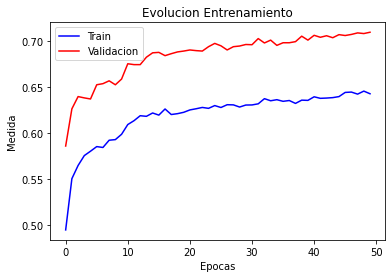

In [20]:
# Showing temporal evolution of accuracy in train and validation sets
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

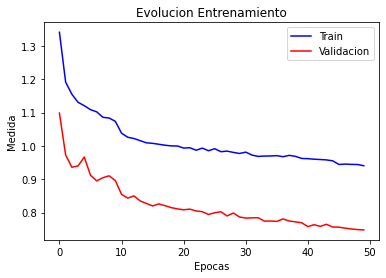

In [21]:
# Showing temporal evolution of loss in train and validation sets
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [22]:
# Model evaluation in test set
metricas = model.evaluate(X_test, Y_test)

63/63 [==============================] - 3s 45ms/step - loss: 0.7471 - accuracy: 0.7668


In [23]:
# Second Training Iteration: fine tunning process by training all the layers
# with previous weights.
densenet.trainable = True

# Hyperparameters definition
epocas = 50   # number of epochs
bs = 20       # batch size
lr = 0.0001  # learning rate

# Model parameters definition
optim = Adam(learning_rate = lr, amsgrad = True)
model.compile(optimizer = optim, loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                              min_lr=0.00001)
# Define checkpoint to save best Phase 2 weights
best_weights_ph2 = "ph2_weights_balanced.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2,
                                                monitor="val_loss",
                                                mode="min",
                                                save_best_only=True,
                                                verbose=1)
callbacks = [reduce_lr, checkpoint]

In [24]:
# Model evaluation in test set
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, validation_data = (X_val, Y_val), callbacks = callbacks)
#historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.1, callbacks = callbacks)

Epoch 1/50
1890/1890 [==============================] - ETA: 0s - loss: 0.9616 - accuracy: 0.6444
Epoch 00001: val_loss improved from inf to 0.56251, saving model to ph2_weights_balanced.hdf5
1890/1890 [==============================] - 215s 114ms/step - loss: 0.9616 - accuracy: 0.6444 - val_loss: 0.5625 - val_accuracy: 0.7886
Epoch 2/50
1890/1890 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7398
Epoch 00002: val_loss improved from 0.56251 to 0.44767, saving model to ph2_weights_balanced.hdf5
1890/1890 [==============================] - 206s 109ms/step - loss: 0.7155 - accuracy: 0.7398 - val_loss: 0.4477 - val_accuracy: 0.8398
Epoch 3/50
1890/1890 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.7774
Epoch 00003: val_loss improved from 0.44767 to 0.36307, saving model to ph2_weights_balanced.hdf5
1890/1890 [==============================] - 205s 108ms/step - loss: 0.6090 - accuracy: 0.7774 - val_loss: 0.3631 - val_accuracy: 0.8679
Epoch

In [25]:
# Loading best weights model (lower val_loss value)
model.load_weights(best_weights_ph2)

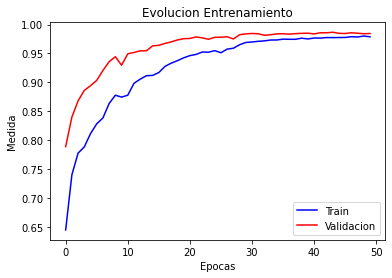

In [26]:
# Showing temporal evolution of accuracy in train and validation sets
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

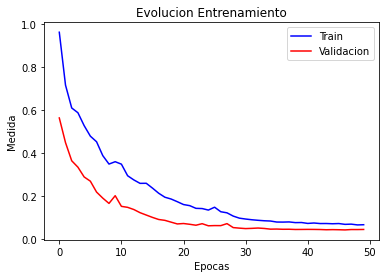

In [27]:
# Showing temporal evolution of loss in train and validation sets
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

**FINAL RESULTS**

In [28]:
# Model evaluation in test set
metricas = model.evaluate(X_test, Y_test)

63/63 [==============================] - 2s 36ms/step - loss: 0.5142 - accuracy: 0.8712


In [29]:
# Obtaining confusion matrix
Y_pred = model.predict(X_test)
print('Confusion Matrix')
print(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

Confusion Matrix
[[  36    5   10    0    5    3    0]
 [   7   81    8    0   14    3    0]
 [   5    3  165    2   32    9    2]
 [   2    1    1   15    6    1    0]
 [   1    1   22    0 1289   21    0]
 [   3    0   25    1   60  133    0]
 [   0    1    0    0    3    1   26]]
